# Learning the Bridge function


In [1]:
import pandas as pd
import numpy as np
from datetime import datetime

import matplotlib
import matplotlib.pyplot as plt

from scipy.interpolate import interpn

from sklearn.metrics import r2_score, mean_squared_error as MSE, mean_absolute_error as MAE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from tensorflow import keras
from tensorflow.python.keras.models import load_model
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense
from tqdm.keras import TqdmCallback

In [2]:
def make_model(input_dim, lam=1e-5):
    model = Sequential()
    model.add(Dense(256, input_dim=input_dim, activation='relu', kernel_regularizer=keras.regularizers.l2(l=lam)))
    model.add(Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(l=lam)))
    model.add(Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(l=lam)))
    model.add(Dense(32, activation='relu', kernel_regularizer=keras.regularizers.l2(l=lam)))
    model.add(Dense(1, activation='linear', kernel_regularizer=keras.regularizers.l2(l=lam)))
    model.summary()

    model.compile(loss='mean_squared_error', optimizer='adam')
    
    return model

def train_model(model, X_train, y_train, y_var, batch_size=128, epochs=100, \
             save_file=False, training_curve=True, val_split=0.1):
    print("Learning MLP model with {} training points".format(len(y_train)))

    try:
        history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, sample_weight=y_var, \
                            validation_split=val_split, verbose=0, callbacks=[TqdmCallback(verbose=1)])
    except KeyboardInterrupt:
        pass
    
    if save_file:
        model.save(save_file)  # creates a HDF5 file 'my_model.h5'
    
    if training_curve:
        # "Loss"
        plt.figure(figsize=(10,8))
        matplotlib.rcParams.update({'font.size': 15})
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'validation'], loc='upper left')
    
    return model

In [3]:
df_hard = pd.read_csv("datasets/hard-train.csv")
X_train_hard = df_hard[["avg_tcf","avg_dcf","fd_gr","avg_grad_icf",]].values
y_train_hard = df_hard[["avg_br"]].values
y_ivar_hard = (df_hard[["err_br"]].values**-2.).ravel()

In [4]:
df_soft = pd.read_csv("datasets/soft-train.csv")
X_train_soft = df_soft[["avg_tcf","avg_dcf","fd_gr","avg_grad_icf",]].values
y_train_soft = df_soft[["avg_br"]].values
y_ivar_soft = (df_soft[["err_br"]].values**-2.).ravel()

In [12]:
df_test_hard = pd.read_csv("datasets/hard-test.csv")
X_test_hard = df_test_hard[["avg_tcf","avg_dcf","fd_gr","avg_grad_icf",]].values
y_test_hard = df_test_hard[["avg_br"]].values

In [13]:
df_test_soft = pd.read_csv("datasets/soft-test.csv")
X_test_soft = df_test_soft[["avg_tcf","avg_dcf","fd_gr","avg_grad_icf",]].values
y_test_soft = df_test_soft[["avg_br"]].values

In [7]:
hard = make_model(4)
soft = make_model(4)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               1280      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 44,545
Trainable params: 44,545
Non-trainable params: 0
_________________________________________________________________


In [3]:
# hard = load_model("models/hard.h5")
# soft = load_model("models/soft.h5")

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Learning MLP model with 166986 training points


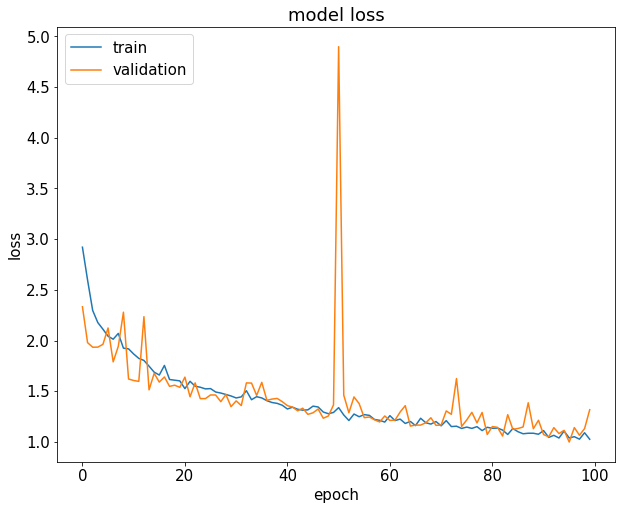

In [8]:
hard = train_model(hard, X_train_hard, y_train_hard, y_ivar_hard, 
                    epochs=100, save_file="models/hard.h5")

Learning MLP model with 166986 training points


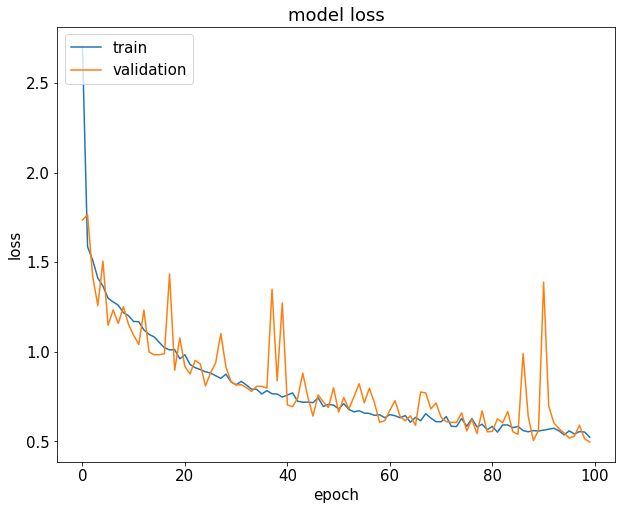

In [9]:
soft = train_model(soft, X_train_soft, y_train_soft, y_ivar_soft, 
                    epochs=100, save_file="models/soft.h5")

In [14]:
y_hard_hard = hard.predict(X_test_hard)
y_soft_hard = hard.predict(X_test_soft)
                          
y_hard_soft = soft.predict(X_test_hard)
y_soft_soft = soft.predict(X_test_soft)

r2_hard_hard = r2_score(y_hard_hard, y_test_hard)
r2_soft_hard = r2_score(y_soft_hard, y_test_soft)
r2_hard_soft = r2_score(y_hard_soft, y_test_hard)
r2_soft_soft = r2_score(y_soft_soft, y_test_soft)

rmse_hard_hard = np.sqrt(MSE(y_hard_hard, y_test_hard))
rmse_soft_hard = np.sqrt(MSE(y_soft_hard, y_test_soft))
rmse_hard_soft = np.sqrt(MSE(y_hard_soft, y_test_hard))
rmse_soft_soft = np.sqrt(MSE(y_soft_soft, y_test_soft))

mae_hard_hard = MAE(y_hard_hard, y_test_hard)
mae_soft_hard = MAE(y_soft_hard, y_test_soft)
mae_hard_soft = MAE(y_hard_soft, y_test_hard)
mae_soft_soft = MAE(y_soft_soft, y_test_soft)

print("Hard-Hard : R2: {:.3f}, RMSE: {:.3f} MAE: {:.3f}".format(r2_hard_hard, rmse_hard_hard, mae_hard_hard))
print("Soft-Hard : R2: {:.3f}, RMSE: {:.3f} MAE: {:.3f}".format(r2_soft_hard, rmse_soft_hard, mae_soft_hard))
print("Hard-Soft : R2: {:.3f}, RMSE: {:.3f} MAE: {:.3f}".format(r2_hard_soft, rmse_hard_soft, mae_hard_soft))
print("Soft-Soft : R2: {:.3f}, RMSE: {:.3f} MAE: {:.3f}".format(r2_soft_soft, rmse_soft_soft, mae_soft_soft))


Hard-Hard : R2: 0.871, RMSE: 0.032 MAE: 0.007
Soft-Hard : R2: 0.011, RMSE: 0.475 MAE: 0.049
Hard-Soft : R2: 0.296, RMSE: 0.106 MAE: 0.023
Soft-Soft : R2: 0.916, RMSE: 0.033 MAE: 0.009


In [16]:
def density_scatter(x , y, colours, ax = None, label=None, sort = True, log=True, bins = 20,  **kwargs )   :
    """
    Scatter plot colored by 2d histogram
    """
    if ax is None :
        fig , ax = plt.subplots()
        
    data , x_e, y_e = np.histogram2d(x, y, bins = bins)
    
    z = interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ) , data , np.vstack([x,y]).T , method = "splinef2d", bounds_error = False )

    # Sort the points by density, so that the densest points are plotted last
    if sort :
        idx = z.argsort()
        x, y, z = x[idx], y[idx], z[idx]
    
    if log:
        z = np.log(z)    
    
    ax.scatter( x, y, c=z, cmap=colours, label=label, **kwargs )
    return ax

/home/reag2/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in log


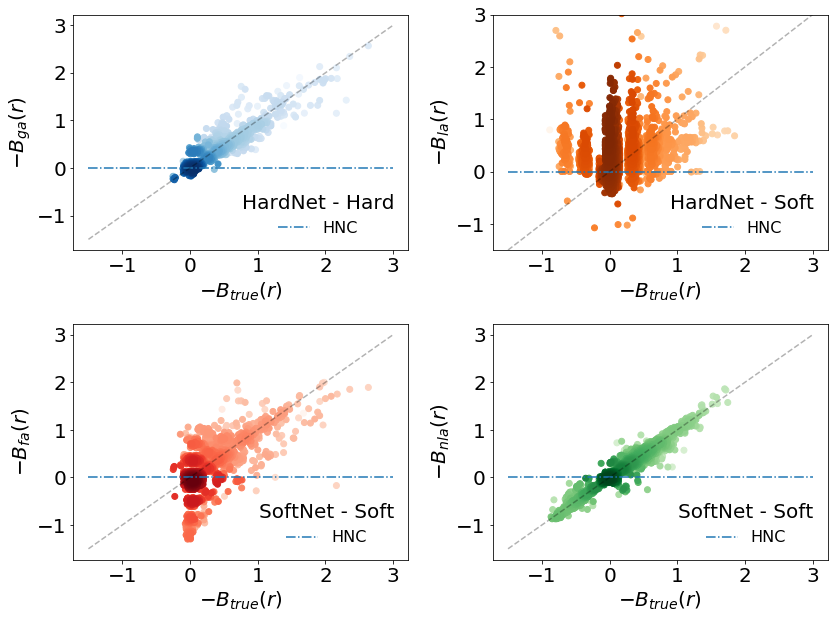

In [24]:
matplotlib.rcParams.update({'font.size': 20})

fig, ax = plt.subplots(2,2, figsize=(12,9))

density_scatter(-y_test_hard.ravel(), -y_hard_hard.ravel(), plt.get_cmap('Blues'), ax=ax[0,0])

density_scatter(-y_test_soft.ravel(), -y_soft_hard.ravel(), plt.get_cmap('Oranges'), ax=ax[0,1])

density_scatter(-y_test_hard.ravel(), -y_hard_soft.ravel(), plt.get_cmap('Reds'), ax=ax[1,0])

density_scatter(-y_test_soft.ravel(), -y_soft_soft.ravel(), plt.get_cmap('Greens'), ax=ax[1,1])

# ax[0,0].plot(-y_test, -y_gam, linestyle="None",
#         marker="+", label='$B_{ga}$', alpha=0.3,mew=3, color="tab:blue")

# ax[0,1].plot(-y_test, -y_local, linestyle="None",
#         marker="+", label='$B_{la}$', alpha=0.3,mew=3, color="tab:orange")

# ax[1,0].plot(-y_test, -y_fluct, linestyle="None",
#         marker="x", label='$B_{fa}$', alpha=0.3,mew=3, color="tab:green")

# ax[1,1].plot(-y_test, -y_non_local, linestyle="None",
#         marker="x", label='$B_{nla}$', alpha=0.3,mew=3, color="tab:red")   

ax[0,0].plot([-1.5, 3], [0, 0], linestyle="-.", label='HNC', color="tab:blue")
ax[0,0].plot([-1.5, 3], [-1.5, 3], linestyle="--", color='k',  alpha=0.3)
ax[0,0].set_xlabel('$-B_{true}(r)$')
ax[0,0].set_ylabel('$-B_{pred}(r)$')

ax[0,1].plot([-1.5, 3], [0, 0], linestyle="-.", label='HNC', color="tab:blue")
ax[0,1].plot([-1.5, 3], [-1.5, 3], linestyle="--", color='k',  alpha=0.3)
ax[0,1].set_xlabel('$-B_{true}(r)$')
ax[0,1].set_ylabel('$-B_{pred}(r)$')
ax[0,1].set_ylim((-1.5,3))

ax[1,0].plot([-1.5, 3], [0, 0], linestyle="-.", label='HNC', color="tab:blue")
ax[1,0].plot([-1.5, 3], [-1.5, 3], linestyle="--", color='k',  alpha=0.3)
ax[1,0].set_xlabel('$-B_{true}(r)$')
ax[1,0].set_ylabel('$-B_{pred}(r)$')

ax[1,1].plot([-1.5, 3], [0, 0], linestyle="-.", label='HNC', color="tab:blue")
ax[1,1].plot([-1.5, 3], [-1.5, 3], linestyle="--", color='k',  alpha=0.3)
ax[1,1].set_xlabel('$-B_{true}(r)$')
ax[1,1].set_ylabel('$-B_{pred}(r)$')

ax[0,0].legend(markerscale=1, fontsize=16, frameon=False, title="HardNet - Hard", loc=4)
ax[0,1].legend(markerscale=1, fontsize=16, frameon=False, title="HardNet - Soft", loc=4)
ax[1,0].legend(markerscale=1, fontsize=16, frameon=False, title="SoftNet - Soft", loc=4)
ax[1,1].legend(markerscale=1, fontsize=16, frameon=False, title="SoftNet - Soft", loc=4)

plt.tight_layout()

# plt.savefig("plots/compare_{}.png".format(datetime.now().strftime("%d-%m-%Y_%I-%M-%S_%p")))
plt.savefig("plots/compare-hard-soft.png")
plt.show()
